# Apply Topic Modelling Analysis on COVID-19 Documents with NMF

This jupyter notebook demonstrates document clustering with NMF topic modelling and producing JSON files with clustering results.

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import re
import pickle
import seaborn as sns
import json
import nltk
import ast
import datetime as dt
import operator
import os
import re
import random 
import pathlib
import timeit
import bar_chart_race as bcr
from wordcloud import WordCloud
from collections import Counter
from sklearn import decomposition
from sklearn.decomposition import NMF
from gensim.models import Word2Vec
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

In [2]:
PUBLICATION_DF = '../data/processed_data/processed_data.tsv'
TFIDF_V = '../data/extracted_features/covid_tfidf_v.pkl'
TFIDF_D = '../data/extracted_features/covid_tfidf_d.pkl'
WV_MODEL = '../data/extracted_features/covid_100d.model'
JSON_PATH = '../data/clusters/'
TECHNICAL_VALIDATION_PATH = '../data/technical_validation/'

## Load data

In [3]:
df = pd.read_csv(PUBLICATION_DF, sep='\t', encoding='utf-8')
V = pickle.load( open(TFIDF_V, "rb"))
D = pickle.load( open(TFIDF_D, "rb"))
w2v_model = Word2Vec.load(WV_MODEL)

In [4]:
df.shape

(557956, 19)

## Identify the optimal topic size by coherence means 

In [17]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if w2v_model.wv.__contains__(pair[0]) and w2v_model.wv.__contains__(pair[1]):
                similarity = w2v_model.wv.similarity(pair[0], pair[1])
                pair_scores.append(max(0, similarity)) # return positive value
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [18]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [19]:
def get_coherence(V, D, w2v_model, No_TOP_KEYOWRDS):

    kmin, kmax = 3, 30
    
    topic_models = []
    k_values = []
    coherences = []
    # try each value of k
    for k in range(kmin,kmax+1):
        # run NMF
        model = decomposition.NMF( init="nndsvd", n_components=k, random_state=1, max_iter=800) # 'nndsvd' works best for sparse data where the most of value are 0
        W = model.fit_transform( D ) # fit vectorization results
        H = model.components_    
        # store for later
        topic_models.append( (k,W,H) )
        # Get top-n topic descriptors 
        term_rankings = []
        for topic_index in range(k):
            term_rankings.append( get_descriptor( V.get_feature_names(), H, topic_index, No_TOP_KEYOWRDS ) )
        # Now calculate the coherence based on our Word2vec model
        k_values.append( k )
        coherences.append( calculate_coherence( w2v_model, term_rankings ) )
        print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )
   
    return k_values, coherences

In [20]:
def show_coherence(k_values, coherences, No_TOP_KEYOWRDS):
    fig = plt.figure(figsize=(12,8))

    ax = plt.plot( k_values, coherences )

    plt.title('Coherence Mean')
    plt.xticks(k_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Mean Coherence")
    plt.grid()
    # add the points
    plt.scatter( k_values, coherences, s=36)
    plt.show()

K=03: Coherence=0.5012
K=04: Coherence=0.4597
K=05: Coherence=0.4679
K=06: Coherence=0.4832
K=07: Coherence=0.4765
K=08: Coherence=0.4924
K=09: Coherence=0.4609
K=10: Coherence=0.4781
K=11: Coherence=0.4633
K=12: Coherence=0.4431
K=13: Coherence=0.4459
K=14: Coherence=0.4384
K=15: Coherence=0.4412
K=16: Coherence=0.4488
K=17: Coherence=0.4414
K=18: Coherence=0.4397
K=19: Coherence=0.4408
K=20: Coherence=0.4435
K=21: Coherence=0.4375
K=22: Coherence=0.4506
K=23: Coherence=0.4384
K=24: Coherence=0.4426
K=25: Coherence=0.4432
K=26: Coherence=0.4522
K=27: Coherence=0.4521
K=28: Coherence=0.4472
K=29: Coherence=0.4470
K=30: Coherence=0.4447


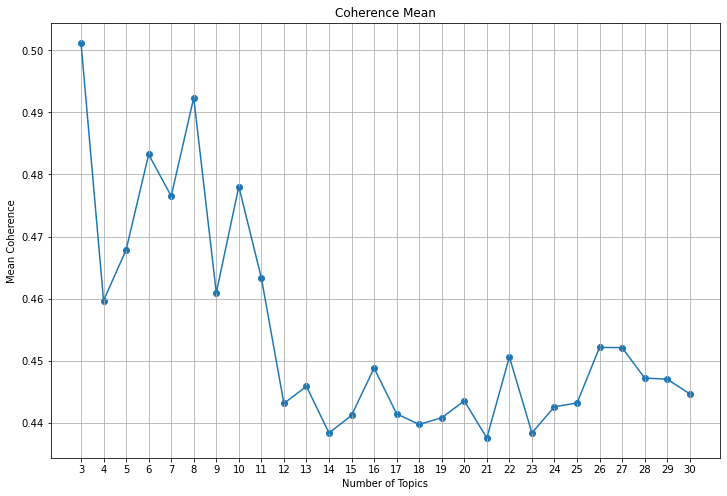

In [21]:
# YOU CAN SKIP THIS CELL
# This function takes approximately one hour to proceed the results

No_TOP_KEYOWRDS = 5
k_values, coherences = get_coherence(V, D, w2v_model, No_TOP_KEYOWRDS)

coherence_df = pd.DataFrame()
coherence_df['k'] = k_values
coherence_df['coherences_mean'] = coherences
coherence_df.to_csv(TECHNICAL_VALIDATION_PATH + "figure5_mean_of_coherence_scores.csv", index=False)

show_coherence(k_values, coherences, No_TOP_KEYOWRDS) 

## Applying topic modelling with the optimal topic size (k)

In [5]:
k = 8
NMF_model = NMF(n_components=k, init='nndsvd', random_state=1).fit(D)
H = NMF_model.transform(D) # articles by topic
W = NMF_model.components_  # topics by words.

In [6]:
# identify first and second topic for each article

top2_clusters_df = pd.DataFrame()
top2_clusters_df['_id'] = df['_id']

top_1_cluster_list=[]
top_2_cluster_list=[]
top_1_cluster_weight_list=[]
top_2_cluster_weight_list=[]
topic_weights_list = []

for a in H:
    top_2_idx = np.argsort(a)[-2:]
    top_2_values = [a[i] for i in top_2_idx]
    weight_dictionary = {}
    for i in range(len(a)):
        weight_dictionary['Cluster#' + '{:02d}'.format(int(i))] = round(a[i], 5)
    topic_weights_list.append(weight_dictionary)
    
    if top_2_values[1] != 0: # if article assign to a cluster
        top_1_cluster_list.append(str(top_2_idx[1]))
        top_2_cluster_list.append(str(top_2_idx[0]))
        top_1_cluster_weight_list.append(top_2_values[1])
        top_2_cluster_weight_list.append(top_2_values[0])
    else: # article is not assign to any cluster
        top_1_cluster_list.append('-')
        top_2_cluster_list.append('-')
        top_1_cluster_weight_list.append(0)
        top_2_cluster_weight_list.append(0)
    
top2_clusters_df['top1_cluster'] = top_1_cluster_list
top2_clusters_df['top2_cluster'] = top_2_cluster_list
top2_clusters_df['top1_cluster_weight'] = top_1_cluster_weight_list
top2_clusters_df['top2_cluster_weight'] = top_2_cluster_weight_list
top2_clusters_df.shape

(557956, 5)

In [7]:
# save the cluster number to dataframe

df['cluster'] = top2_clusters_df['top1_cluster']
df['cluster-correlation'] = topic_weights_list

In [8]:
def converter(x):
    try:
        x = int(x)
        return 'Cluster#' + '{:02d}'.format(int(x))
    except:
        return '-'
df['cluster'] = df['cluster'].apply(lambda x: converter(x))

## Explore the topic modelling results

### Number of articles per month

In [9]:
tmp_df = df.copy()
tmp_df['YearMonth'] = pd.to_datetime(tmp_df['created']).dt.to_period('M')
tmp_df['Year'] = pd.to_datetime(tmp_df['created']).dt.to_period('Y')

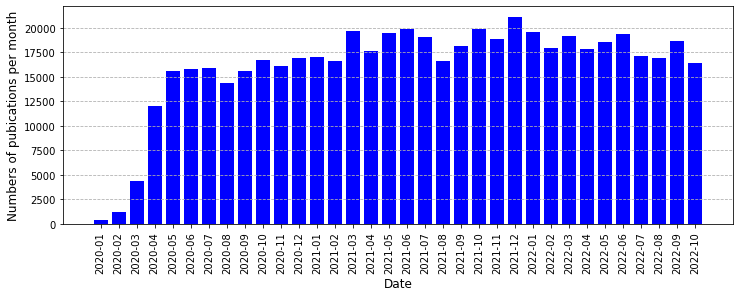

In [11]:
# 2020-2022

count_df = tmp_df[['created','YearMonth']].groupby('YearMonth').count().reset_index()
count_df.columns = ['year_month', 'number_of_articles']
count_df.year_month = count_df.year_month.astype(str)

months = list(count_df['year_month'].iloc[-34:])
values = list(count_df['number_of_articles'].iloc[-34:]) 
fig = plt.figure(figsize = (12, 4))
# creating the bar plot
plt.bar(months, values, color='blue')
plt.xticks(rotation=90) 
plt.xlabel("Date", fontsize=12)
plt.ylabel("Numbers of pubications per month", fontsize=12)
plt.grid(True, axis='y', linestyle='--')

plt.show()

In [12]:
count_df.to_csv(TECHNICAL_VALIDATION_PATH + "figure3_cornavirus_themed_articles_by_month.csv", index=False)

### Top keywords

In [13]:
def get_top_keyword_weights(model, optimal_topic_size, n_top_words, V):
    
    feat_names = V.get_feature_names()
    
    word_dict = {};
    for i in range(optimal_topic_size):
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Cluster # ' + '{:02d}'.format(i)] = words;
    
    return pd.DataFrame(word_dict);

In [16]:
def get_top_keyword_weights(model, optimal_topic_size, n_top_words, V):
    feature_names = V.get_feature_names()
    keywords_df = pd.DataFrame()
    k = 0
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        keywords_df["cluster{}_keywords".format(k)] = top_features
        keywords_df["cluster{}_keywords_weights".format(k)] = weights
        k +=1
    return keywords_df

In [17]:
def print_top_keyword_weights(model, optimal_topic_size, n_top_words, V):
    feature_names = V.get_feature_names()
    fig, axes = plt.subplots(2, 4, figsize=(30, 16), sharex=True)
    axes = axes.flatten()
   
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
    
        for p in ax.patches:
            if topic_idx == 0:
                ax.annotate(str(round(p.get_width(),2)), (6.5, p.get_y() + p.get_height()),size=16)
            else:
                ax.annotate(str(round(p.get_width(),2)), (5.5, p.get_y() + p.get_height()),size=16)
        ax.set_title(f"Cluster# {topic_idx}", fontdict={"fontsize": 20})
        
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

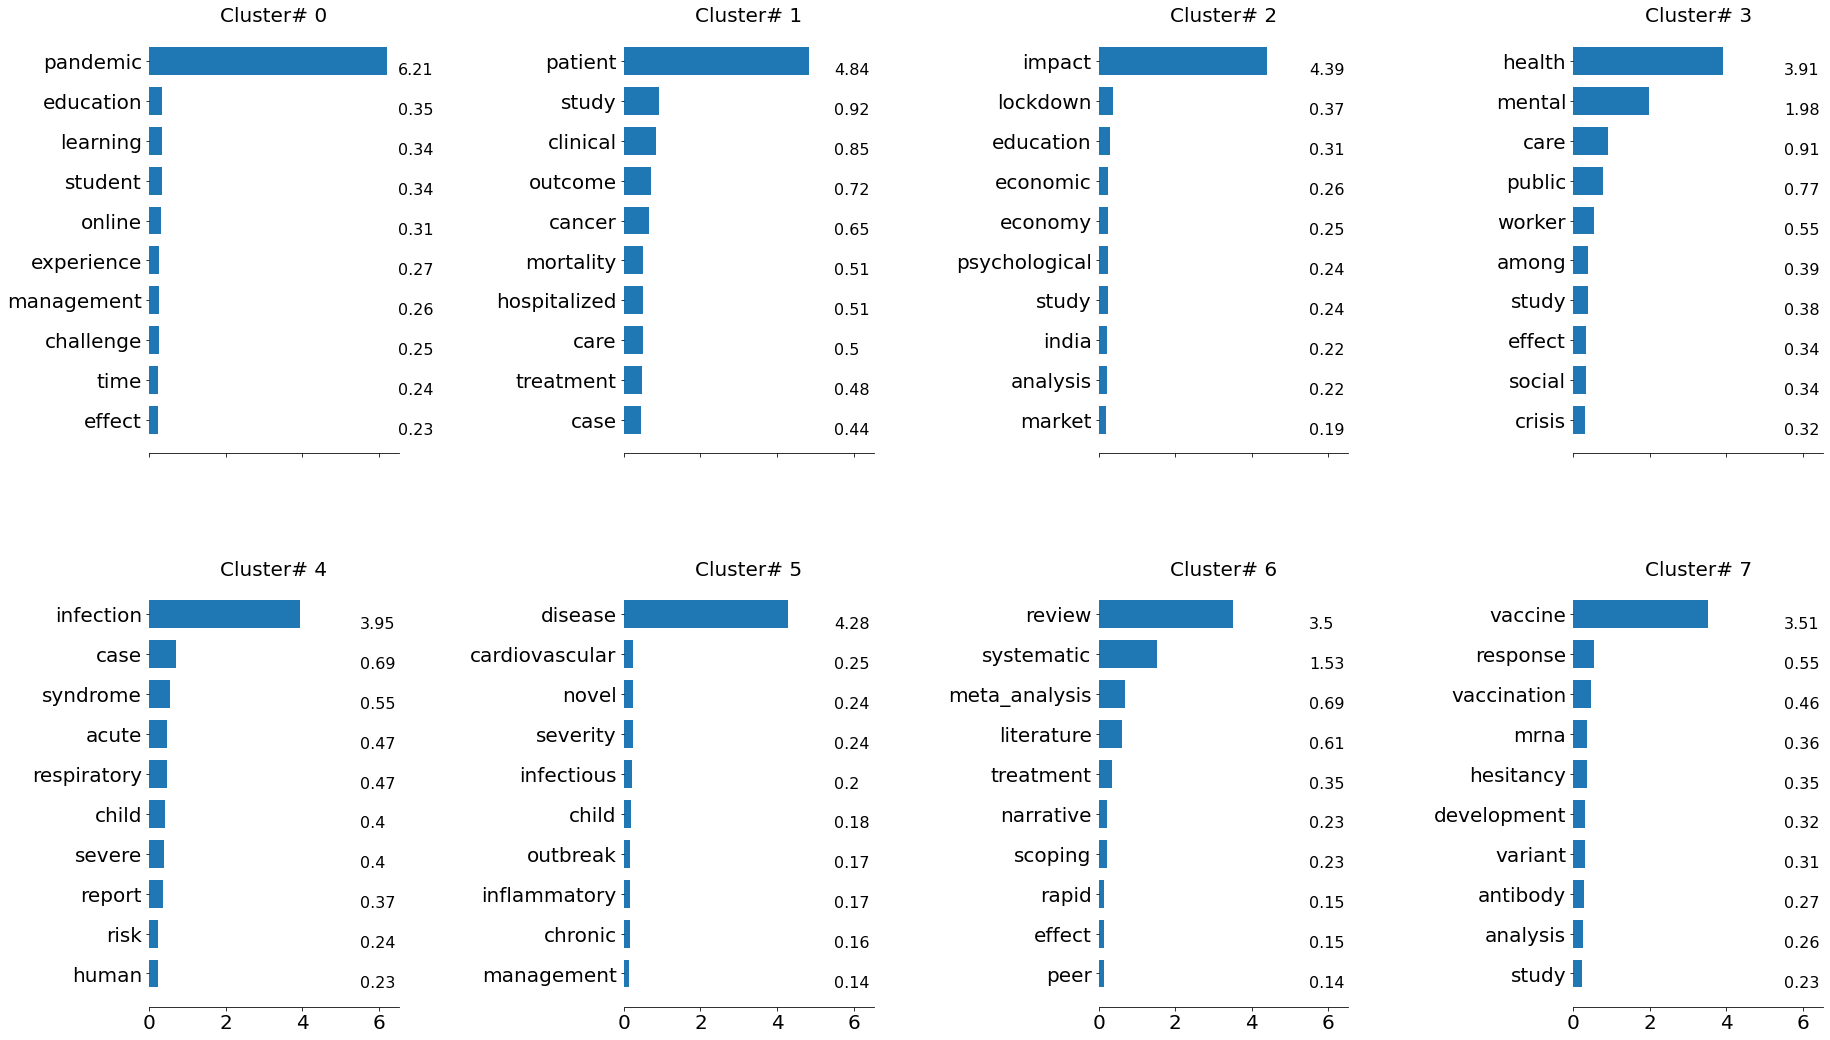

In [18]:
keywords_df = get_top_keyword_weights(NMF_model, k, 100, V)
keywords_df.to_csv(TECHNICAL_VALIDATION_PATH + "figure6_top_keywords_for_clusters.csv", index=False)
print_top_keyword_weights(NMF_model, k, 10, V)

### Print the number of articles in the clusters

In [20]:
def show_distribution(unique, top1_num_of_articles):
    plt.figure(figsize=(12, 6))

    plt.bar(unique, top1_num_of_articles)
    plt.yticks(fontsize=14)
    plt.xticks(unique, unique)
    plt.ylabel('Number of research articles', fontweight='bold', fontsize=14)
    plt.xlabel('Clusters', fontweight='bold', fontsize=14)
    plt.ylim(0, 120000)
    for index, value in enumerate(top1_num_of_articles):
        plt.text(index-0.3, top1_num_of_articles[index]+1000, f"{top1_num_of_articles[index]:,}", fontsize=12)
    plt.legend()

    plt.show()

In [23]:
# count the number of article across clusters
clusters = range(k)
articles_num = []
for cluster in range(k):
    articles_num.append(len(top2_clusters_df.loc[top2_clusters_df['top1_cluster'] == str(cluster)]))
    
dist_df = pd.DataFrame()
dist_df['clusters'] = clusters
dist_df['num_of_articles'] = articles_num

dist_df.to_csv(TECHNICAL_VALIDATION_PATH + "figure13_distribution_of_articles.csv", index=False)

No handles with labels found to put in legend.


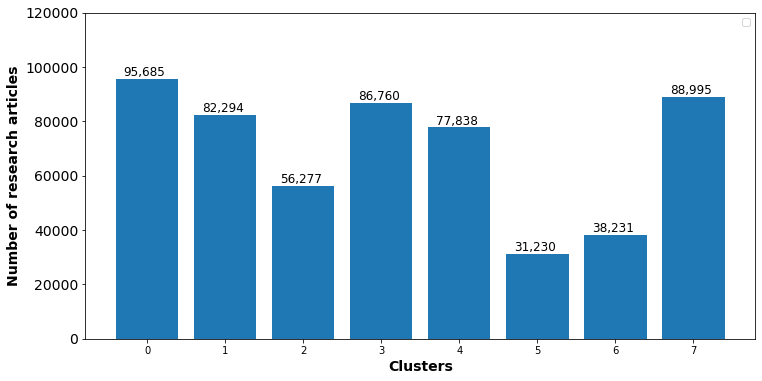

In [22]:
# show the number of articles per cluster 
show_distribution(unique, articles_num)

### Article co-occurrence 

In [24]:
# Identify Sum of x and number of x

c_pair_x_num = {} # coumt number of x
c_pair_x_sum = {} # sum of x
for index, row in top2_clusters_df.loc[top2_clusters_df['top1_cluster']!='-'].iterrows():
    c_pair = (row['top1_cluster'], row['top2_cluster'])
    if c_pair not in c_pair_x_num.keys():
        c_pair_x_num[c_pair] = 1
    else:
        c_pair_x_num[c_pair] += 1

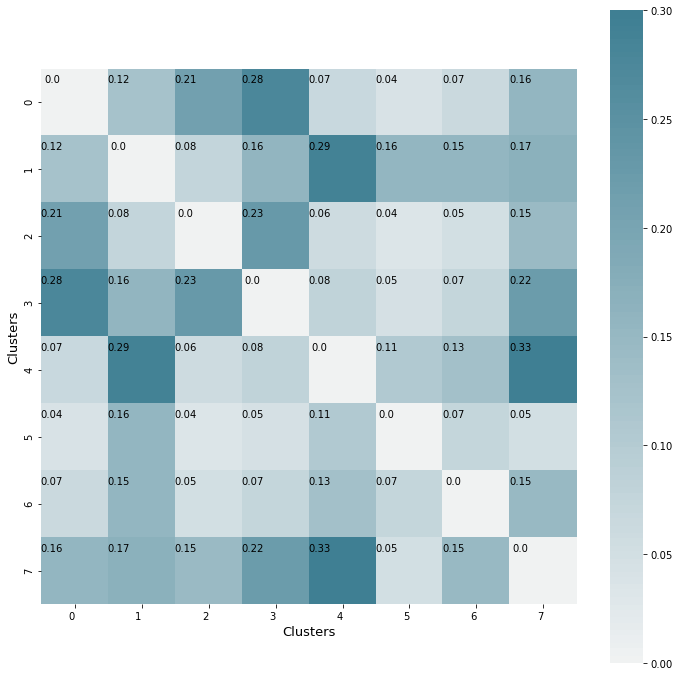

In [27]:
co_oc_df = pd.DataFrame(columns=['first_cluster', 'second_cluster', 'number_of_articles'])
for i in range(k):
    for j in range(k):
        if i == j:continue
        co_oc_df = co_oc_df.append({
            "first_cluster":str(i),
            "second_cluster":str(j),
            "number_of_articles":str(c_pair_x_num[(str(i), str(j))] + c_pair_x_num[(str(j), str(i))])}, ignore_index=True)

# convert DF to matrix format
matrix_df = pd.DataFrame()
for c1 in range(k):
    placeholders = []
    for c2 in range(k):
        placeholders.append(0)
    matrix_df[c1] = placeholders
    
for index, row in co_oc_df.iterrows():
    cluster1 = int(str(row['first_cluster']).replace('.0', ''))
    cluster2 = int(str(row['second_cluster']).replace('.0', ''))
    
    cooccurrence = row['number_of_articles']
    num_articles_in_first_collection = len(top2_clusters_df.loc[top2_clusters_df['top1_cluster'] == str(cluster1)])
    num_articles_in_second_collection = len(top2_clusters_df.loc[top2_clusters_df['top1_cluster'] == str(cluster2)])
    co_rate = round(int(cooccurrence)/(num_articles_in_first_collection + num_articles_in_second_collection), 3)
    matrix_df[cluster2].iloc[cluster1] = co_rate

fig, ax = plt.subplots(figsize=(12,12))         
ax = sns.heatmap(
    matrix_df, 
    vmin=0, vmax=0.3, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    horizontalalignment='right'
);
j = k
for c in matrix_df.columns:
    i = 0
    for index, row in matrix_df.iterrows():
        value = row[c]
        ax.text(i/k+0.02, j/k-0.02, round(value, 2), horizontalalignment='center',
             verticalalignment='center', transform=ax.transAxes)
        i += 1
    j -= 1
plt.xlabel('Clusters', fontsize = 13) 
plt.ylabel('Clusters', fontsize = 13) 

plt.show()

In [29]:
co_oc_df.to_csv(TECHNICAL_VALIDATION_PATH + "figure10_co-occurrence_rate.csv", index=False)

### Topic weights (co-efficient)

In [24]:
def draw_box_plot(data):
    fig = plt.figure(figsize =(8, 4))
 
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])

    # Creating plot
    bp = ax.boxplot(data)
    ax.set_title('Cluster coefficients by clusters')
    ax.set_xlabel("Clusters")
    ax.set_ylabel("Cluster weights (coefficient)")
    # show plot
    plt.show()

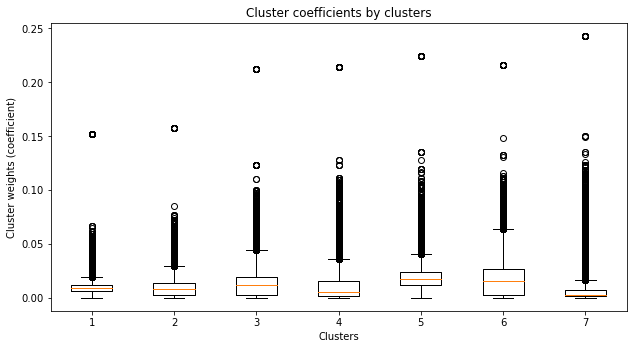

In [25]:
# Import libraries

cluster_0_weights = top2_clusters_df['top1_cluster_weight'].loc[top2_clusters_df['top1_cluster'] == '0']
cluster_1_weights = top2_clusters_df['top1_cluster_weight'].loc[top2_clusters_df['top1_cluster'] == '1']
cluster_2_weights = top2_clusters_df['top1_cluster_weight'].loc[top2_clusters_df['top1_cluster'] == '2']
cluster_3_weights = top2_clusters_df['top1_cluster_weight'].loc[top2_clusters_df['top1_cluster'] == '3']
cluster_4_weights = top2_clusters_df['top1_cluster_weight'].loc[top2_clusters_df['top1_cluster'] == '4']
cluster_5_weights = top2_clusters_df['top1_cluster_weight'].loc[top2_clusters_df['top1_cluster'] == '5']
cluster_6_weights = top2_clusters_df['top1_cluster_weight'].loc[top2_clusters_df['top1_cluster'] == '6']
cluster_7_weights = top2_clusters_df['top1_cluster_weight'].loc[top2_clusters_df['top1_cluster'] == '7']

data = [cluster_0_weights, cluster_1_weights, cluster_2_weights, cluster_4_weights,
       cluster_5_weights, cluster_6_weights, cluster_7_weights]

draw_box_plot(data)

### Cluster trend

In [30]:
def bumpchart(df, selected_collections, show_rank_axis= True, rank_axis_distance= 1.1, 
              ax= None, scatter= False, holes= False,
              line_args= {}, scatter_args= {}, hole_args= {}):
    
    fig = plt.figure(figsize=(9,5))
    if ax is None:
        left_yaxis= plt.gca()
    else:
        left_yaxis = ax

    # Creating the right axis.
    right_yaxis = left_yaxis.twinx()
    
    axes = [left_yaxis, right_yaxis]
    
    # Creating the far right axis if show_rank_axis is True
    if show_rank_axis:
        far_right_yaxis = left_yaxis.twinx()
        axes.append(far_right_yaxis)
    flag = 0
    for col in df.columns:
        y = df[col]
        x = df.index.values
        # Plotting blank points on the right axis/axes 
        # so that they line up with the left axis.
        for axis in axes[1:]:
            axis.plot(x, y, alpha= 0)
            
        if col not in selected_collections:
            left_yaxis.plot(x, y, **line_args, solid_capstyle='round', color='grey', alpha=0.1)
            
            # Adding scatter plots
            if scatter:
                left_yaxis.scatter(x, y, **scatter_args, color='green', alpha=0.1)
                
                #Adding see-through holes
                if holes:
                    bg_color = left_yaxis.get_facecolor()
                    left_yaxis.scatter(x, y, color= bg_color, **hole_args)
        else: # highlight selected values
            if flag != 1: c = 'red'
            else: c='blue'
            left_yaxis.plot(x, y, **line_args, solid_capstyle='round', color=c, label=col)
            left_yaxis.legend(loc='upper right', fontsize=12)
            left_yaxis.set_xlabel("Date")
            left_yaxis.set_ylabel("Rank")
            # Adding scatter plots
            if scatter:
                left_yaxis.scatter(x, y, **scatter_args, color=c)

                #Adding see-through holes
                if holes:
                    bg_color = left_yaxis.get_facecolor()
                    left_yaxis.scatter(x, y, color= bg_color, **hole_args)
            flag = 1
    # Number of lines
    lines = len(df.columns)
    y_ticks = [*range(0, lines)]
    
    x_ticks = []
    for j in range(1, len(df.index)+1, 12):
        x_ticks.append(rank_cum_table.index[j])
    
    # Configuring the axes so that they line up well.
    for axis in axes:
        axis.invert_yaxis()
        axis.set_yticks(y_ticks)
        axis.set_ylim((lines + 0.5, 0.5))
    
    # Sorting the labels to match the ranks.
    left_labels = df.iloc[0].sort_values().index
    right_labels = df.iloc[-1].sort_values().index
    
    axis.xaxis.set_major_locator(plt.MaxNLocator(12))
    
    return axes

In [37]:

tmp_df = df.copy()
tmp_df['date'] = pd.to_datetime(tmp_df['created']).dt.to_period('M')
sorted_df = tmp_df.sort_values(by=['date'], inplace=False) # sort by date

groupby_sub_df = sorted_df.groupby(['date', 'cluster'])["_id"].count().reset_index(name="count")

# convert pivot table, thus each topic become column where value indicate number of document
table = pd.pivot_table(groupby_sub_df, values='count', index=['date'],
                    columns=['cluster'], aggfunc=np.sum, fill_value=0)

table = table.reindex(sorted(table.columns), axis=1)

# convert table where values are cumulative
cum_table = table.cumsum(axis=0)

rank_cum_table = pd.DataFrame(columns=list(cum_table.columns))
i = 0
for index, row in cum_table.iterrows():
    l = cum_table.iloc[i]
    result = [sorted(l, reverse=True).index(x)+1 for x in l]
    rank_cum_table.loc[i] = result
    i += 1

In [40]:
rank_cum_table_copy = rank_cum_table.drop(columns=['-'],inplace=False)
rank_cum_table_copy.rename(columns={'Cluster#00':'Cluster#00'.lower(),
                                   'Cluster#01':'Cluster#01'.lower(),
                                    'Cluster#02':'Cluster#02'.lower(),
                                    'Cluster#03':'Cluster#03'.lower(),
                                    'Cluster#04':'Cluster#04'.lower(),
                                    'Cluster#05':'Cluster#05'.lower(),
                                    'Cluster#06':'Cluster#06'.lower(),
                                    'Cluster#07':'Cluster#07'.lower(),
                                   }, inplace=True)

In [41]:
rank_cum_table_copy.to_csv(TECHNICAL_VALIDATION_PATH + "figure14_research_topic_trends.csv", index=False)

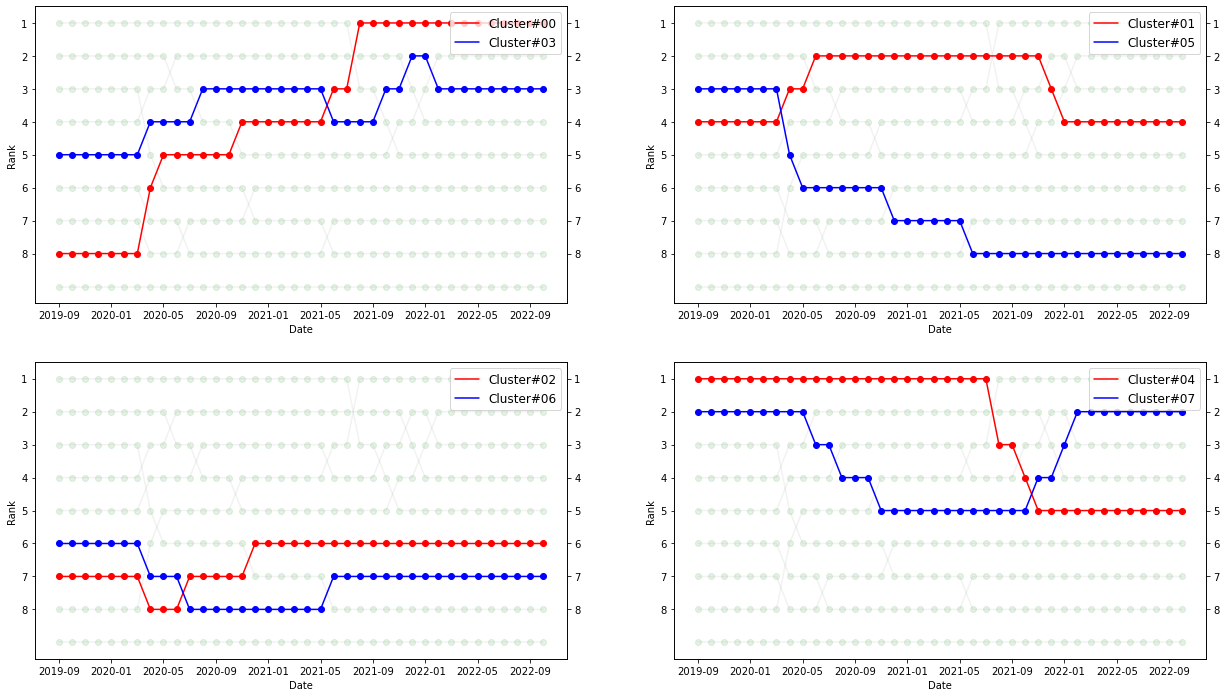

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

In [28]:
rank_cum_table.index= cum_table.index

fig, axs = plt.subplots(2,2, figsize=(21,12))
last_month = 38
rank_cum_table.index = rank_cum_table.index.astype(str)

bumpchart(rank_cum_table.tail(last_month), ['Cluster#00', 'Cluster#03'], show_rank_axis= False, scatter=True, ax=axs[0][0])
bumpchart(rank_cum_table.tail(last_month), ['Cluster#01', 'Cluster#05'], show_rank_axis= False, scatter=True, ax=axs[0][1])
bumpchart(rank_cum_table.tail(last_month), ['Cluster#02', 'Cluster#06'], show_rank_axis= False, scatter=True, ax=axs[1][0])
bumpchart(rank_cum_table.tail(last_month), ['Cluster#04', 'Cluster#07'], show_rank_axis= False, scatter=True, ax=axs[1][1])

**To create coronavirus publication clusters video**

You need to download 'ffmpeg'from https://ffmpeg.org/download.html.

In [43]:
cum_table.drop(columns=['-'], inplace=True)

tmp_df = cum_table.rename(columns={
    'Cluster#00':'Cluster 0 - Pandemic',
    'Cluster#01':'Cluster 1 - Patient',
    'Cluster#02':'Cluster 2 - (Socio-economic) Impact',
    'Cluster#03':'Cluster 3 - (Public and Mental) Health',
    'Cluster#04':'Cluster 4 - Infection',
    'Cluster#05':'Cluster 5 - Disease',
    'Cluster#06':'Cluster 6 - Literature and meta analysis',
    'Cluster#07':'Cluster 7 - Vaccine',
}, inplace=False)

bcr.bar_chart_race(df = tmp_df.tail(46), filename=None, figsize=(4.5, 4), title='Coronavirus publication clusters (2019-2022)')

### Wordcloud

In [42]:
def getRandomCol():
    r = random.randrange(30, 180)
    g = random.randrange(30, 180)
    b = random.randrange(30, 180)
    return (r, g, b)

def show_wordcloud(df):
    i = 0
    fig = plt.figure(figsize=(18,5))
    for t in range(k):
        ax = fig.add_subplot(2,4,i+1)
        topic_df = df.loc[df['cluster'] == 'Cluster#' + '{:02d}'.format(int(t))]
        text = ''
        for index, row in topic_df.iterrows():
            text += row['text']
        wordcloud = WordCloud(background_color="white", collocations=False).generate(str(text))
        plt.title("Cluster {}".format(t))
        colour = getRandomCol()
        ax.imshow(wordcloud.recolor(color_func=lambda *args, **kwargs: colour))
        ax.axis('off')
        i += 1
    plt.tight_layout()
    
    plt.show()

In [ ]:
"""
word_freq_df = pd.DataFrame()
for t in range(k):
    topic_df = df.loc[df['cluster'] == 'Cluster#' + '{:02d}'.format(int(t))]
    word_freq_df['cluster_{}_words'.format(t)] = topic_df.text.str.split(expand=True).stack().value_counts().keys()[:100]
    word_freq_df['cluster_{}_words_frequency'.format(t)] = topic_df.text.str.split(expand=True).stack().value_counts().values[:100]
    word_freq_df.to_csv(TECHNICAL_VALIDATION_PATH + "figure7_wordcloud.csv", index=False)
"""

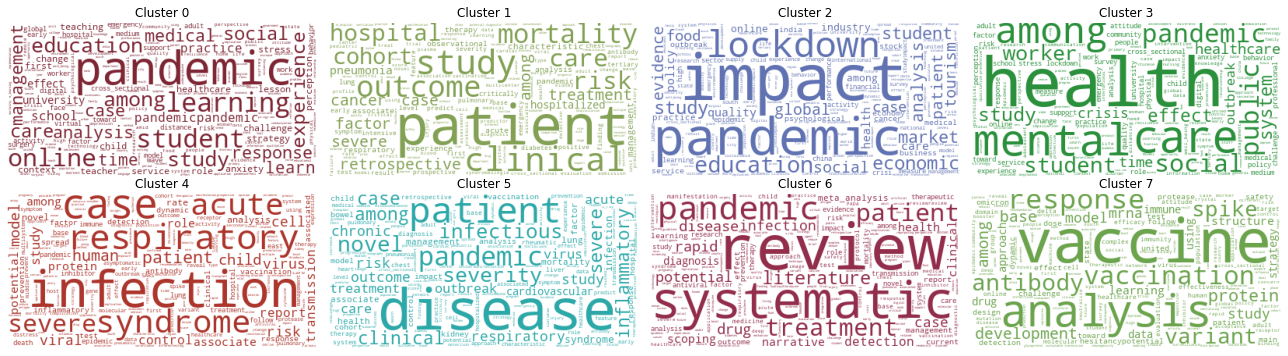

In [35]:
show_wordcloud(df)

### MetaData 

In [57]:
def count_publisher(df):
    missing_article = df['publisher'].isnull().sum()
    percent = round(missing_article/len(df)*100, 1)
    print("Number of publications without publisher: {} ({}%)".format(missing_article, percent))
    publisher_df = df.groupby('publisher')['_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
    publisher_df.columns = ['publisher','number_of_articles']
    publisher_df.head(20).to_csv(TECHNICAL_VALIDATION_PATH + "figure11_top_publishers.csv", index=False)
    return publisher_df

In [58]:
def count_subjects(df):
    missing_article = df['subject'].isnull().sum()
    print("Number of publications without subject: {} ({}%)".format(missing_article, round(missing_article/len(df)*100, 1)))
    subjects_dict = {}
    for index, row in df.iterrows():
        if len(str(row['subject'])) > 3:
            subjects = eval(row['subject'])
            for s in subjects:
                if s in subjects_dict.keys():
                    subjects_dict[s] += 1
                else:
                    subjects_dict[s] = 1

    sorted_sub_dict = dict( sorted(subjects_dict.items(), key=operator.itemgetter(1),reverse=True))
    subject_df = pd.DataFrame()
    subject_df['subjects'] = sorted_sub_dict.keys()
    subject_df['number_of_articles'] = sorted_sub_dict.values()
    subject_df.head(20).to_csv(TECHNICAL_VALIDATION_PATH + "figure11_top_subjects.csv", index=False)
    return subject_df

In [59]:
def count_container(df):
    df['container-title'] = df['container-title'].astype(str)
    missing_article = len(df.loc[df['container-title'] == 'nan'])
    print("Number of publications without container: {} ({}%)".format(missing_article, round(missing_article/len(df)*100, 1)))
    df = df.loc[df['container-title'] != 'nan']
    container_df = df.groupby('container-title')['_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
    container_df.columns = ['container_title','number_of_articles']
    container_df['container_title'] = container_df['container_title'].apply(lambda x: x.replace("['", ''))
    container_df['container_title'] = container_df['container_title'].apply(lambda x: x.replace("']", ''))
    container_df.head(20).to_csv(TECHNICAL_VALIDATION_PATH + "figure11_top_journals.csv", index=False)
    return container_df

In [64]:
def count_funder(df):
    df['funder'] = df['funder'].astype(str)
    missing_article = len(df.loc[df['funder'] == 'nan'])
    print("Number of publications without funder: {} ({}%)".format(missing_article, round(missing_article/len(df)*100, 1)))
    tmp_df = df.loc[df['funder'] != 'nan']
    funder_dict = {}
    for index, row in tmp_df.iterrows():
        if len(str(row['funder'])) > 3:
            funders = eval(row['funder'])
            for f in funders:
                if f in funder_dict.keys():
                    funder_dict[f] += 1
                else:
                    funder_dict[f] = 1
    sorted_funder_dict = dict( sorted(funder_dict.items(), key=operator.itemgetter(1),reverse=True))
    funder_df = pd.DataFrame()
    funder_df['funders'] = sorted_funder_dict.keys()
    funder_df['number_of_articles'] = sorted_funder_dict.values()
    funder_df.head(20).to_csv(TECHNICAL_VALIDATION_PATH + "figure11_top_funder.csv", index=False)
    return funder_df

In [65]:
def draw_subplots(top_n, df1, df2, df3, df4):
    fig, axs = plt.subplots(4,1,figsize=(11,18))
    
    x = list(df1['publisher'].iloc[:top_n])
    y = list(df1['number_of_articles'].iloc[:top_n])     
    axs[0].barh(x, y, color='#728FCE')
    # top shows biggest value
    axs[0].invert_yaxis() 
    # for showing values on bar
    for p in axs[0].patches:
        axs[0].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=10)
    axs[0].title.set_text("Top publishers")
    
    
    x = list(df2['subjects'].iloc[:top_n])
    y = list(df2['number_of_articles'].iloc[:top_n])     
    axs[1].barh(x, y, color='#7BCCB5')
    # top shows biggest value
    axs[1].invert_yaxis() 
    # for showing values on bar
    for p in axs[1].patches:
        axs[1].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=10)
    axs[1].title.set_text("Top subjects")
    
    x = list(df3['container_title'].iloc[:top_n])
    y = list(df3['number_of_articles'].iloc[:top_n])     
    axs[2].barh(x, y, color='#FFE87C')
    # top shows biggest value
    axs[2].invert_yaxis() 
    # for showing values on bar
    for p in axs[2].patches:
        axs[2].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=10)
    axs[2].title.set_text("Top journals/conferences")
    
    x = list(df4['funders'].iloc[:top_n])
    y = list(df4['number_of_articles'].iloc[:top_n])     
    axs[3].barh(x, y)
    # top shows biggest value
    axs[3].invert_yaxis() 
    # for showing values on bar
    for p in axs[3].patches:
        axs[3].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=10)
    axs[3].title.set_text("Top funders")
    
    #plt.savefig('top-10-articles-metadata.png'.format(top_n), doi='400', bbox_inches='tight')     
    

Number of publications without publisher: 250 (0.0%)
Number of publications without subject: 213170 (38.2%)
Number of publications without container: 73234 (13.1%)
Number of publications without funder: 486138 (87.1%)


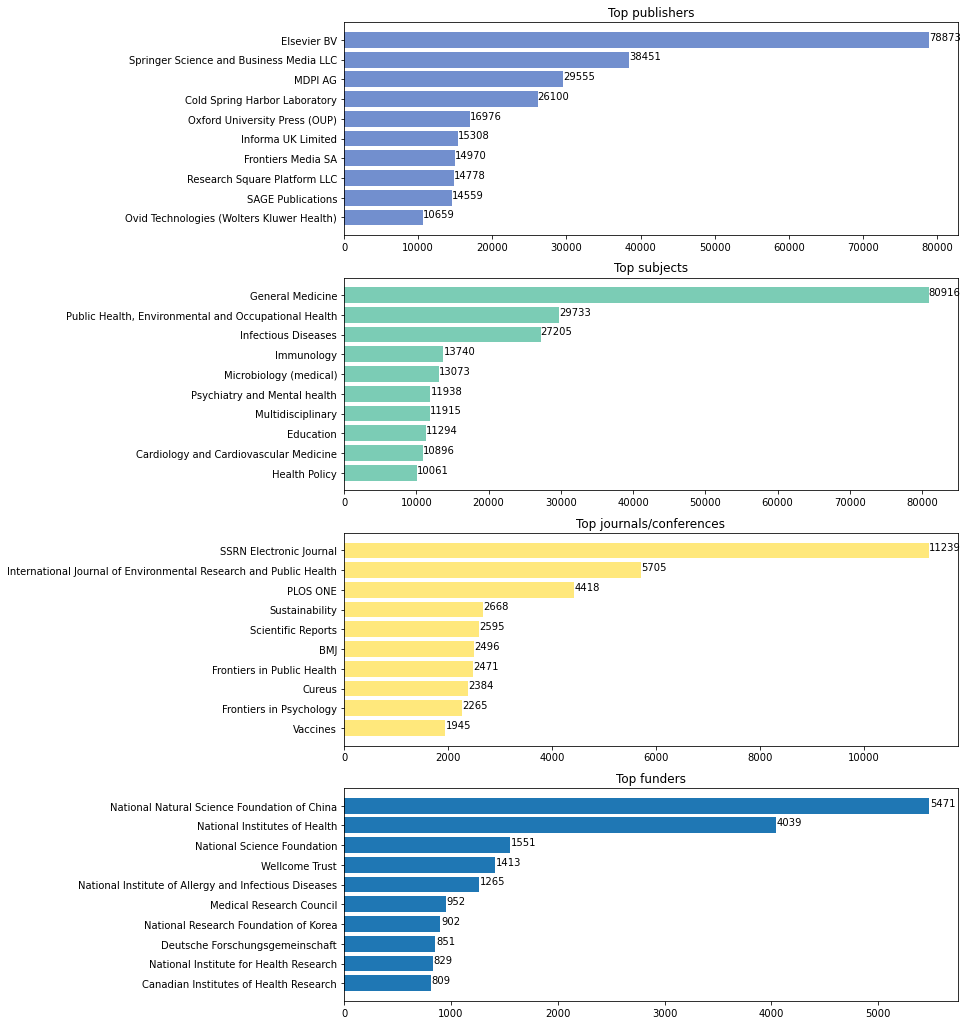

In [66]:
top_n = 10
draw_subplots(top_n, count_publisher(df), count_subjects(df), count_container(df), count_funder(df))

### Metadata dependency matrix

In [42]:
def draw_heatmap(df, metadata):
    
    fig = plt.figure(figsize=(8,5))
    #plt.title(metadata, fontsize = 13, fontweight="bold")
    x_axis_labels = [0, 1, 2, 3, 4, 5, 6, 7]
    conf_matrix_df = df.set_index(metadata)
    sns.heatmap(conf_matrix_df, annot=True, cmap="crest", xticklabels=x_axis_labels)
    sns.set(font_scale=1.2)
    plt.xlabel('Clusters')
     
    plt.show()

Number of publications without publisher: 250 (0.0%)


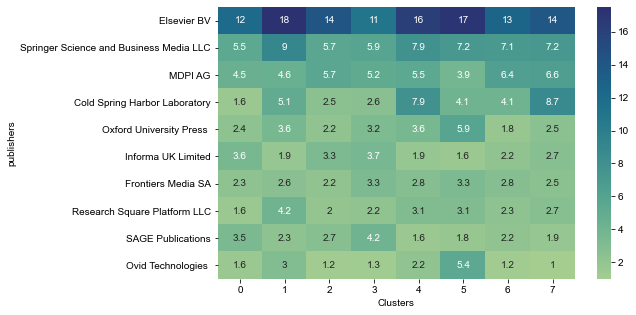

In [43]:
metadata = 'publisher'

# get top n publishers
publishers_df = count_publisher(df)
top_publishers = publishers_df.publisher[:top_n]
top_publishers = list(map(lambda x: re.sub("\(.*?\)|\[.*?\]","",x), top_publishers))

# create dependency matrix to save the percentage of articles with the publisher
publisher_df = pd.DataFrame()
publisher_df['publishers'] = top_publishers

for i in range(k):
    tmp_list = []
    tmp_df = df.loc[df['cluster'] == 'Cluster#' + '{:02d}'.format(int(i))]
    tmp_with_metadata_df = tmp_df.loc[tmp_df[metadata].notnull()]
    for w in top_publishers:
        num_of_articles_with_metadata = len(tmp_with_metadata_df.loc[tmp_with_metadata_df[metadata].str.contains(w)])
        tmp_list.append(round(num_of_articles_with_metadata/len(tmp_with_metadata_df)*100, 1))
    publisher_df['cluster#{}'.format(str(i))] = tmp_list
publisher_df.to_csv(TECHNICAL_VALIDATION_PATH + "figure12_percentage_of_articles_in_the_top_10_publishers.csv", index=False)   
draw_heatmap(publisher_df, 'publishers')

Missing subject: 213170 (38.2%)


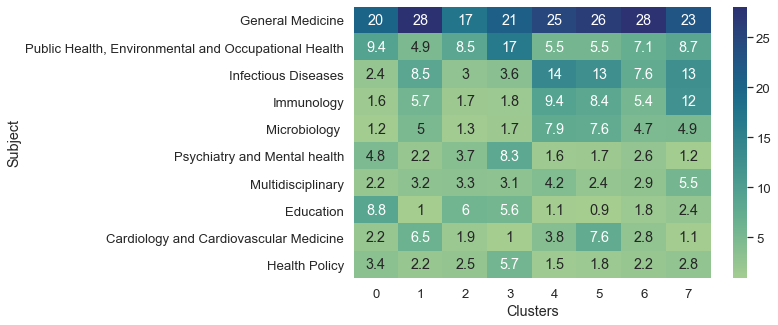

In [44]:
metadata = 'Subject'

# get top n publishers
subject_df = count_subjects(df)
top_subjects = subject_df.Subjects[:top_n]
top_subjects = list(map(lambda x: re.sub("\(.*?\)|\[.*?\]","",x), top_subjects))

# create dependency matrix to save the percentage of articles with the publisher
subject_df = pd.DataFrame()
subject_df[metadata] = top_subjects


for i in range(k):
    tmp_list = []
    tmp_df = df.loc[df['cluster'] == 'Cluster#' + '{:02d}'.format(int(i))]
    tmp_with_metadata_df = tmp_df.loc[tmp_df['subject'].notnull()]
    for w in top_subjects:
        num_of_articles_with_metadata = len(tmp_with_metadata_df.loc[tmp_with_metadata_df['subject'].str.contains(w)])
        tmp_list.append(round(num_of_articles_with_metadata/len(tmp_with_metadata_df)*100, 1))
    subject_df['cluster#{}'.format(str(i))] = tmp_list
subject_df.to_csv(TECHNICAL_VALIDATION_PATH + "figure12_percentage_of_articles_in_the_top_10_subjects.csv", index=False)   
draw_heatmap(subject_df, 'Subject')

Missing container: 73234 (13.1%)


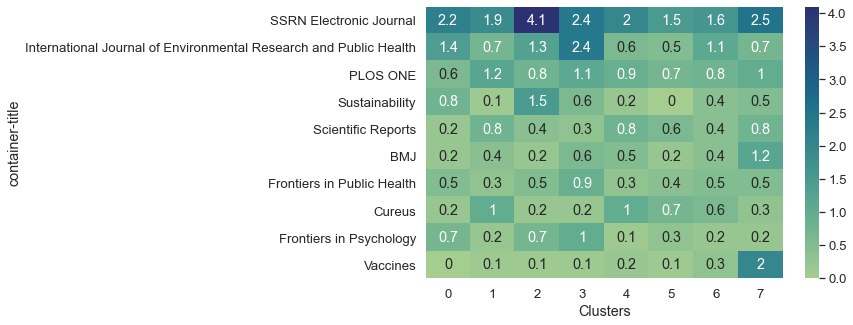

In [45]:
metadata = 'container-title'

# get top n publishers
journal_df = count_container(df)
top_journals = journal_df['container_title'][:top_n]
top_journals = list(map(lambda x: re.sub("\(.*?\)|\[.*?\]","",x), top_journals))

# create dependency matrix to save the percentage of articles with the journal
# code modified as string contain capture irrelevant journal

journal_df = pd.DataFrame()
journal_df[metadata] = top_journals

for i in range(k):
    tmp_list = []
    tmp_df = df.loc[df['cluster'] == 'Cluster#' + '{:02d}'.format(int(i))]
    tmp_with_metadata_df = tmp_df.loc[tmp_df[metadata] != 'nan']
    for w in top_journals:
        num_of_articles_with_metadata = len(tmp_with_metadata_df.loc[tmp_with_metadata_df[metadata] == "{}".format(w)])
        tmp_list.append(round(num_of_articles_with_metadata/len(tmp_with_metadata_df)*100, 1))
    journal_df['cluster#{}'.format(str(i))] = tmp_list
journal_df.to_csv(TECHNICAL_VALIDATION_PATH + "figure12_percentage_of_articles_in_the_top_10_journals.csv", index=False)   
draw_heatmap(journal_df, 'container-title')

Missing funder: 486138 (87.1%)


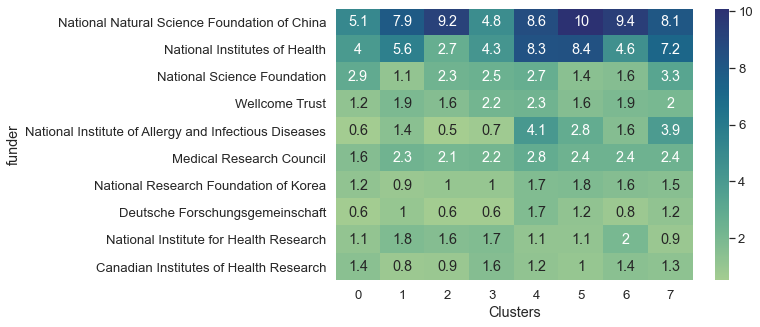

In [46]:
metadata = 'funder'

# get top n funder
funder_df = count_funder(df)
top_funder = funder_df['Funders'][:top_n]
top_funder = list(map(lambda x: re.sub("\(.*?\)|\[.*?\]","",x), top_funder))

# create dependency matrix to save the percentage of articles with the funder

funder_df = pd.DataFrame()
funder_df[metadata] = top_funder

for i in range(k):
    tmp_list = []
    tmp_df = df.loc[df['cluster'] == 'Cluster#' + '{:02d}'.format(int(i))]
    tmp_with_metadata_df = tmp_df.loc[tmp_df[metadata] != 'nan']
    for w in top_funder:
        num_of_articles_with_metadata = len(tmp_with_metadata_df.loc[tmp_with_metadata_df[metadata].str.contains(w)])
        tmp_list.append(round(num_of_articles_with_metadata/len(tmp_with_metadata_df)*100, 1))
    funder_df['cluster#{}'.format(str(i))] = tmp_list
funder_df.to_csv(TECHNICAL_VALIDATION_PATH + "figure12_percentage_of_articles_in_the_top_10_funder.csv", index=False)   
draw_heatmap(funder_df, 'funder')

## Save results 

In [62]:
sorted_df = df.sort_values(by=['created'], inplace=False) # sort by date

sorted_df['volume'] = sorted_df['volume'].astype(str)
sorted_df['issue'] = sorted_df['issue'].astype(str)
sorted_df['created'] = sorted_df['created'].astype(str)
sorted_df['published'] = sorted_df['published'].astype(str)

before_2020_df = sorted_df.loc[sorted_df['created'] < '2020-01'] 
after_2020_df = sorted_df.loc[sorted_df['created'] > '2020-01'] 

before_2020_df = before_2020_df.reset_index()
after_2020_df = after_2020_df.reset_index()

before_2020_df.drop(columns=['index'], inplace=True)
after_2020_df.drop(columns=['index'], inplace=True)

In [63]:
# wrtie JSON pre 2020

for c in range(k):
    selected_cluster = 'Cluster#' + '{:02d}'.format(int(c))
    tmp_df = before_2020_df.loc[before_2020_df['cluster'] == selected_cluster]
    tmp_df = tmp_df.reset_index()
    dict_records = tmp_df.to_dict('records')
    CLUSTER_PARH = JSON_PATH + 'cluster{}/pre_2020/'.format(c)
    if not os.path.exists(CLUSTER_PARH):
        os.makedirs(CLUSTER_PARH)
    for i, r in tmp_df.iterrows():
        doi = tmp_df['DOI'].iloc[i]
        doi = doi.replace('/', '-')
        with open(CLUSTER_PARH+'{}.json'.format(doi), 'w') as f:
            json.dump(dict_records[i], f,ensure_ascii=False, indent=2)

In [64]:
# wrtie JSON post 2020
for c in range(k):
    selected_cluster = 'Cluster#' + '{:02d}'.format(int(c))
    tmp_df = after_2020_df.loc[after_2020_df['cluster'] == selected_cluster]
    for Y in range(2020, 2023):
        for M in range(1, 12):
            if M < 10: M = "0"+str(M)
            tmp_month_df = tmp_df.loc[tmp_df['created'].str.contains("{}-{}".format(Y, M))] # select data by date
            if len(tmp_month_df) == 0:continue
            tmp_month_df = tmp_month_df.reset_index() # reset index
            tmp_month_df.drop(columns=['index'], inplace=True)
            dict_records = tmp_month_df.to_dict('records')

            POST_2020_PATH = JSON_PATH+'cluster{}/{}-{}/'.format(c, Y, M)

            for i, r in tmp_month_df.iterrows():
                doi = tmp_month_df['DOI'].iloc[i]
                doi = doi.replace('/', '-')
                if not os.path.exists(POST_2020_PATH):
                    os.makedirs(POST_2020_PATH)          
                with open(POST_2020_PATH+'{}.json'.format(doi), 'w') as f:
                    json.dump(dict_records[i], f,ensure_ascii=False, indent=2)